In [50]:
"""
Debug lenmap2gclm
"""
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import pysht
import cupy as cp
import sys
from time import process_time
from lenspyx.lensing import get_geom as get_lenspyxgeom
from delensalot.sims.sims_lib import Xunl, Xsky
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from delensalot.utility.plot_helper import bandpass_alms

from pysht.helper import dlm2A

magnific = None
runinfos = [
    ("CPU", "lenspyx", 'ducc'),
    # ("CPU", "duccnufft", 'ducc'),
    ("GPU", "cufinufft", 'shtns')
    ]
epsilon = 1e-14
deflection_epsilon = 1e-14
lmaxs = [511]

phi_lmaxs = [lmax for lmax in lmaxs]
defres = {}
Tsky = None
Tsky2 = None
for lmax, phi_lmax in zip(lmaxs, phi_lmaxs):
    geominfo = ('gl',{'lmax': lmax})
    lenjob_geominfo = ('gl',{'lmax': phi_lmax})
    # geominfo = ('tgl',{'lmax': lmax, 'smax':2})
    # lenjob_geominfo = ('tgl',{'lmax': phi_lmax, 'smax':2})
    lldlm = np.arange(0, phi_lmax+1)
    synunl = Xunl(lmax=lmax, geominfo=geominfo, phi_lmax=phi_lmax)
    synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo, epsilon=epsilon)
    philm = synunl.get_sim_phi(0, space='alm')
    toydlm = hp.almxfl(philm, np.sqrt(np.arange(phi_lmax + 1, dtype=float) * np.arange(1, phi_lmax + 2)))
    toydlm *= 0.
    philm *= 0.
    toyunllm = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
    Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
    Tsky2 = synsky.unl2len(toyunllm, philm, spin=0)
    for runinfo in runinfos:
        shttransformer_desc = 'shtns' if runinfo[0] == 'GPU' else 'ducc'
        kwargs = {
            'geominfo': geominfo,
            'nthreads': 10,
            'epsilon': epsilon,
            'verbosity': 1,
            'planned': False,
            'single_prec': False,
            'shttransformer_desc': shttransformer_desc
        }
        
        deflection_kwargs = {
            'geominfo': lenjob_geominfo,
            'nthreads': 10,
            'epsilon': deflection_epsilon,
            'verbosity': 1,
            'single_prec': False,
            'mmax_dlm': phi_lmax, # this is merely to cut out the m-modes.
            'dlm': toydlm,
        }
        print(runinfo)
        backend = runinfo[0]
        defres.update({backend: {}}) if backend not in defres.keys() else None
        solver = runinfo[1]
        defres[backend].update({solver : None}) if solver not in defres[backend].keys() else None
        for mode in ['nuFFT']:
            print("\nTesting:: solver = {} backend = {} mode = {} ...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(**kwargs, deflection_kwargs=deflection_kwargs)
            print("\n----lmax: {}, phi_lmax: {}, dlm_lmax = {}, epsilon: {}----".format(lmax, phi_lmax, hp.Alm.getlmax(toydlm.size), deflection_kwargs['epsilon']))
            
            if runinfo[0] == 'CPU':
                magnific = dlm2A(toydlm, phi_lmax, phi_lmax, get_lenspyxgeom(kwargs['geominfo']), kwargs['nthreads'], None)
            
            if backend == 'CPU':
                if solver == 'lenspyx':
                    nalm = toyunllm.shape[-1]
                    gclm = np.array(np.zeros(shape=(1, nalm)), dtype=np.complex128) if not kwargs["single_prec"] else np.array(np.zeros(shape=(nalm)), dtype=np.complex64)
                    _ = Tsky.copy()
                    print(_.shape)
                    # _ = bandpass_alms(_, 0, 100)
                    for ofs, w, nph in zip(t.geom.ofs, t.geom.weight, t.geom.nph):
                        _[ofs:ofs + nph] *= w
                    defres[backend][solver] = t.lenmap2gclm(
                        np.atleast_2d(_), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, gclm_out=gclm, nthreads=10, execmode='debug', ptg=None)
                else:
                    gclm = np.array(np.zeros(shape=(1, t.geom.nalm(lmax, lmax))), dtype=np.complex128) if not kwargs["single_prec"] else np.array(np.zeros(shape=(t.geom.nalm(lmax, lmax))), dtype=np.complex64)
                    _ = Tsky.copy()
                    for ofs, w, nph in zip(t.geom.ofs, t.geom.weight, t.geom.nph):
                        _[ofs:ofs + nph] *= w
                    defres[backend][solver] = t.lenmap2gclm(
                            np.atleast_2d(_), dlm=toydlm, gclm_out=gclm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, execmode='debug')
            elif backend == 'GPU':
                lenmap = np.atleast_2d((Tsky))#.reshape(t.geom.nph[0],-1).T.flatten()) # this only works for gl geom
                lenmap = cp.array(lenmap, dtype=np.complex128) if not kwargs["single_prec"] else cp.array(lenmap.astype(np.complex64))
                ll = np.arange(0,deflection_kwargs["mmax_dlm"]+1,1)
                dlm_scaled = hp.almxfl(toydlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))
                dlm_scaled = cp.array(np.atleast_2d(dlm_scaled), dtype=np.complex128) if not deflection_kwargs["single_prec"] else cp.array(np.atleast_2d(dlm_scaled).astype(np.complex64))
                gclm = cp.array(np.zeros(shape=(1,t.geom.nalm(lmax, lmax))), dtype=np.complex128) if not kwargs["single_prec"] else cp.array(np.zeros(shape=(1,t.geom.nalm(lmax, lmax))), dtype=np.complex64)
                defres[backend][solver] = t.lenmap2gclm(lenmap, dlm_scaled=dlm_scaled, lmax=lmax, mmax=lmax, spin=0, gclm_out=gclm, nthreads=10, execmode='debug')

INFO:: 04-23 18:23:01:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-23 18:23:01:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU


INFO:: 04-23 18:23:01:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-23 18:23:01:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
512 512 512 512
inside _build_d1
lmax_dlm:  511
mmax_dlm:  511
----
shape d1:  (2, 524288)
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
shape d1:  (2, 524288)
lmax_dlm:  511
mmax_dlm:  511
shapes:  (512,) (512,) (512,) (512,) (2, 524288)
(524288, 3)
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (131328,)
    spin: ()
    lmax: ()
    mmax: ()
    nthreads: ()
  Output shape: [(524288,)], types: [<class 'numpy.ndarray'>]
512 512 512 512
inside _build_d1
lmax_dlm:  511
mmax_dlm:  511
----
shape d1:  (2, 524288)
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
shape d1:  (2, 524288)
lmax_dlm:  511
mmax_dlm:  511
shapes:  (512,) (512,) (512,) (512,) (2, 524288)
(524288, 3)
('CPU', 'lenspyx', 'ducc')

Testing:: solver = lenspyx backend = CPU mode = nuFFT ...
deflection std is 


Total wall clock time for adjoint_synthesis_general: 0.03533s
|
+- deinterpol (nu2u)                 : 70.50% (0.0249s)
+- updateAlm                         : 26.68% (0.0094s)
|  |
|  +- phi FFT and deconvolution         : 39.75% (0.0037s)
|  +- theta resampling and deconvolution: 33.64% (0.0032s)
|  +- leg2alm                           : 25.35% (0.0024s)
|  +- dealing with borders              :  1.19% (0.0001s)
|  
+- build_planes                      :  2.31% (0.0008s)
+- SphereInterpol setup              :  0.51% (0.0002s)
+- setup                             :  0.00% (0.0000s)


          fftw cost ifftc=0,  fftc=0
          Memory used for Ylm and Zlm matrices = 769.500 Mb x2
        => using Gauss nodes
          Sum of weights = 2 + 1.33227e-15 (should be 2)
          Applying quadrature rule to 3/2.x^2 = 1 + 1.11022e-16 (should be 1)
          Applying quadrature rule to 3/4.sin2(theta) = 1 + 2.77556e-16 (should be 1)
 NLAT=512, NLAT_2=256
          max zero at Gauss nodes for Pl[l=NLAT] : 5.43014e-13
        + polar optimization threshold = 1.0e-10
          tm[im]= 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8 8 9 9 9 10 10 10 10 11 11 11 11 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 16 16 16 16 17 17 17 17 18 18 18 19 19 19 19 20 20 20 20 21 21 21 22 22 22 22 23 23 23 24 24 24 24 25 25 25 26 26 26 26 27 27 27 28 28 28 28 29 29 29 30 30 30 30 31 31 31 32 32 32 33 33 33 33 34 34 34 35 35 35 35 36 36 36 37 37 37 38 38 38 38 39 39 39 40 40 40 41 41 41 42 42 42 42 43 43 43 44 44 44 45 45 45 45 46 

/tmp/ipykernel_2265805/4137546419.py:107: RuntimeWarning: divide by zero encountered in divide
  dlm_scaled = hp.almxfl(toydlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))


- - - - - - - - - - - - - - - Timing adjointsynthesis: 0.000 seconds- - - - - - - - - - - - - - - 

::debug:: Returned component results


In [39]:
from lenspyx.tests.helper import syn_ffi_ducc_29, cls_unl
from lenspyx.utils import timer
from lenspyx.utils_hp import Alm, synalm
import numpy as np
import pylab as pl
import healpy as hp

tim = timer(True)
ffi, _ = syn_ffi_ducc_29(lmax_len=phi_lmax, dlmax=0, dlmax_gl=0, dlm=toydlm, epsilon=epsilon)
Aunl = ffi.dlm2A()

lmax, mmax = phi_lmax, phi_lmax
# tlm_unl = synalm(cls_unl['tt'][:lmax + 1], lmax, mmax).astype(np.complex64)
tmap_len = ffi.gclm2lenmap(toyunllm, mmax, 0, backwards=False)

points1 = tmap_len.copy()
# for ofs, w, nph in zip(ffi.geom.ofs, ffi.geom.weight, ffi.geom.nph):
    # points1[ofs:ofs + nph] *= w
points1 = points1
points2 = tmap_len * Aunl
# for ofs, w, nph in zip(ffi.geom.ofs, ffi.geom.weight, ffi.geom.nph):
    # points2[ofs:ofs + nph] *= w
points2 = points2

tlm_unl_1 = ffi.lenmap2gclm(points1, 0, lmax, mmax).astype(np.complex128)
tlm_unl_2 = ffi.lenmap2gclm(points2, 0, lmax, mmax).astype(np.complex128)
# tlm_unl_3 = ffi.lenmap2gclm(np.atleast_2d(Tsky2), 0, lmax, mmax).astype(np.complex128)

deflection std is 2.48e+00 amin
512 512 512 512
deflection: I set numthreads to 40
 DUCC 40 threads deflection instantiated 1e-14
inside _build_d1
lmax_dlm:  511
mmax_dlm:  511
----
shape d1:  (2, 414542)
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
shape d1:  (2, 414542)
lmax_dlm:  511
mmax_dlm:  511
shapes:  (512,) (512,) (512,) (512,) (2, 414542)
(414542, 3)
  dlm2A                                :  [0:00:00.031424] (50.3%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:00.006366] (10.2%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.004911] (7.9%)  
  build_angles                         :  [0:00:00.011291] (18.1%)  
  synthesis general (STANDARD)         :  [0:00:00.019202] (30.8%)  
  gclm2lenmap                          :  [0:00:00.030570] (49.0%)  
  Total                                :  [0:00:00.062438] d:h:m:s:mus



Total wall clock time for synthesis_general: 0.0191s
|
+- interpol (u2nu)                   : 51.13% (0.0098s)
+- getPlane                          : 47.88% (0.0091s)
|  |
|  +- theta resampling and deconvolution: 36.16% (0.0033s)
|  +- alm2leg                           : 32.03% (0.0029s)
|  +- phi FFT and dconvolution          : 29.69% (0.0027s)
|  +- dealing with borders              :  2.06% (0.0002s)
|  
+- SphereInterpol setup              :  0.96% (0.0002s)
+- build_planes                      :  0.01% (0.0000s)
+- setup                             :  0.00% (0.0000s)

Total wall clock time for adjoint_synthesis_general: 0.01806s
|
+- deinterpol (nu2u)                 : 57.36% (0.0104s)
+- updateAlm                         : 38.83% (0.0070s)
|  |
|  +- theta resampling and deconvolution: 42.07% (0.0030s)
|  +- leg2alm                           : 29.20% (0.0020s)
|  +- phi FFT and deconvolution         : 27.03% (0.0019s)
|  +- dealing with borders              :  1.61% (0.0001s)
|

[]

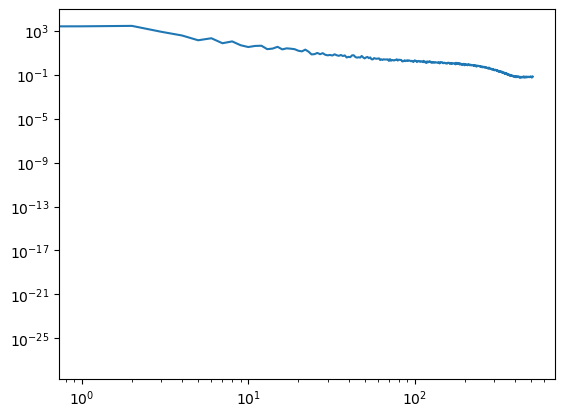

In [40]:
Tsky2_lm = t.map2alm(Tsky2.reshape(t.constructor.spat_shape[::-1]).T)
Tsky2_lm.shape
plt.plot(hp.alm2cl(Tsky2_lm[0]))
plt.loglog()

[21.62004675+0.j         21.85131608+0.j         31.36219399+0.j
 ...  0.03164548-0.12130539j -0.30851579+0.06313782j
  0.25050904-0.17805858j] (131328,)


(0.95, 1.158)

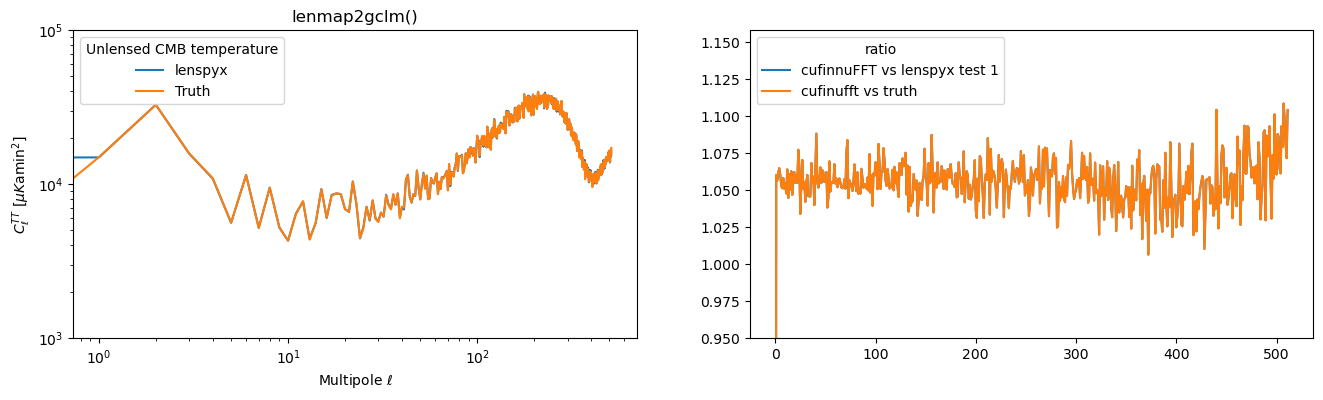

In [43]:
key = 'adjointsynthesis'
keyCPU = 'adjointsynthesisgeneral'
solverCPU, solverGPU = 'lenspyx', 'cufinufft'
fig, ax = plt.subplots(1,2, figsize=(16,4))

ll = np.arange(1,phi_lmax+2)*np.arange(2, phi_lmax+3)
resCPU = defres['CPU'][solverCPU][keyCPU][0]
resGPU = defres['GPU'][solverGPU][key][0]
print(resGPU, toyunllm.shape)
# print(defres['CPU'][solverCPU][key][0][0].shape)

ax[0].plot(ll*hp.alm2cl(resCPU.astype(complex)), label=solverCPU)
# ax[0].plot(ll*hp.alm2cl(resGPU.astype(complex)), label=solverGPU)
ax[0].plot(ll*hp.alm2cl(toyunllm), label='Truth')

# ax[0].plot(ll*1e-10*hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')
# ax[0].plot(ll*1e-10*hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen*A)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_ylim(1e3, 1e5)
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

ax[1].plot((hp.alm2cl(toyunllm.astype(complex)))/hp.alm2cl(resGPU.astype(complex)), label='cufinnuFFT vs lenspyx test 1')
# ax[1].plot(1e-10*(hp.alm2cl(tlm_unl_2.astype(complex)))/hp.alm2cl(resGPU.astype(complex)), label='cufinnuFFT vs lenspyx test 2 ')
ax[1].plot((hp.alm2cl(toyunllm))/hp.alm2cl(resGPU.astype(complex)), label='cufinufft vs truth')
ax[1].legend(title='ratio')
# ax[1].loglog()
# ax[1].set_ylim(-1e-1,1e-1)
# ax[1].set_ylim(1.012,1.06)
ax[1].set_ylim(0.95,1.158)

# ax[1].set_xscale('log')
# ax[1].plot(hp.alm2cl(), label=solverGPU)

In [48]:
defres['CPU'][solverCPU].keys()

dict_keys(['dlm2pointing', 'adjointsynthesisgeneral'])

## Compare with lenpyx test

In [ ]:
key = 'adjointsynthesis'
solverCPU, solverGPU = 'lenspyx', 'duccnufft'
vmin=-1e-10
vmax=1e-10
fig, ax = plt.subplots(1,3, figsize=(16,4))
print(defres['CPU'][solverCPU]["adjointsynthesisgeneral"][0][0].shape)

# ax[0].plot(hp.alm2cl(defres['CPU'][solverCPU]["adjointsynthesisgeneral"][0][0]), label=solverCPU)
ax[0].plot(hp.alm2cl(defres['CPU'][solverGPU][key][0][0]), label=solverGPU)
ax[0].plot(hp.alm2cl(toyunllm), label='Truth')

# ax[0].plot(hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')
# ax[0].plot(hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen*A)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

ax[1].plot(hp.alm2cl(tlm_unl_1.astype(complex))/hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen)')
ax[1].set_ylim(0.99,1.21)

ax[2].plot(Tsky2-tmap_len[0])
ax[2].set_xlim(0,10000)

# CPU vs GPU

## Only for lenpsyx

In [ ]:
keyGPU = 'nuFFT'
keyCPU = 'synthesisgeneral'
# Tsky = Tsky2

vmin, vmax = -4e2, 4e2
resCPU = defres['CPU']['lenspyx'][keyCPU].real
resGPU = resCPU #defres['GPU'][keyGPU][0].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(((resCPU-resGPU).reshape(lmax+1,-1)), vmin=-1e-8, vmax=1e-8)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-resCPU).reshape(lmax+1,-1)), vmin=-1e-5, vmax=1e-5)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-resGPU).reshape(lmax+1,-1)), vmin=-1e-2, vmax=1e-2)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
keyGPU = 'dlm2pointing'
keyCPU = 'pointing'
solverCPU, solverGPU = 'lenspyx', 'duccnufft'

print(defres['CPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['CPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['CPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1) - defres['CPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1) - defres['CPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

In [ ]:
keyGPU = 'dlm2pointing'
keyCPU = 'pointing'
solverCPU, solverGPU = 'lenspyx', 'cufinufft'

print(defres['GPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1) - defres['GPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1) - defres['GPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

In [ ]:
defres['CPU'].keys()

# all others

### pointing things

(2, 2097152) (2, 2097152)


/tmp/ipykernel_2251848/1683915390.py:16: RuntimeWarning: invalid value encountered in divide
  ax[2,1].imshow((defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1)) / defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)


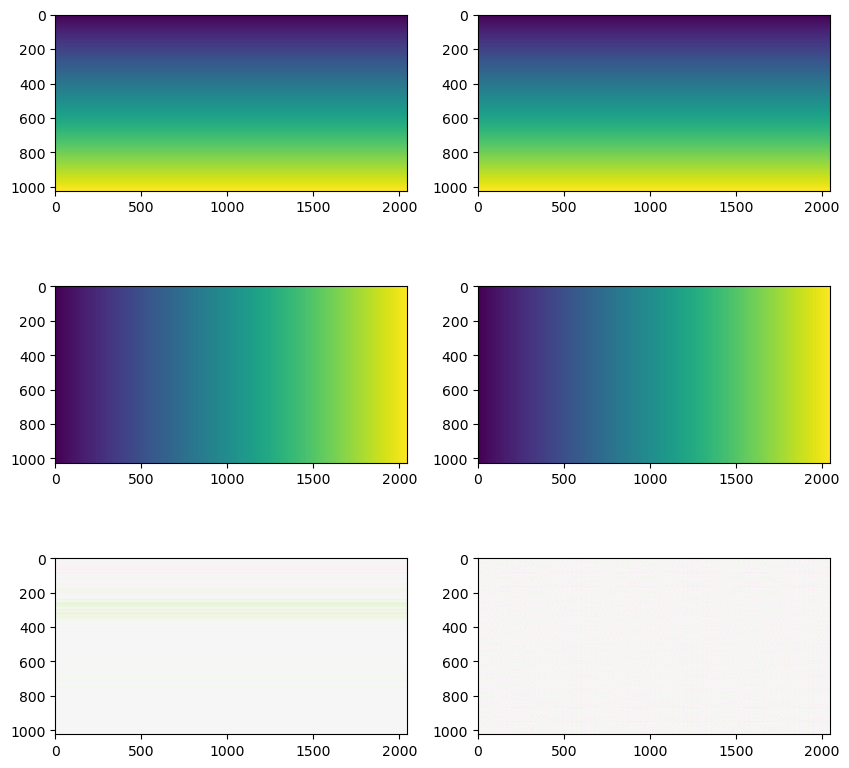

In [5]:
key = 'dlm2pointing'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1))


vmin, vmax = -1e-15, 1e-15
ax[2,0].imshow((defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1)) / defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)
ax[2,1].imshow((defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1)) / defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)

## synthesis general

(1, 2062, 2048) (2062, 2048)


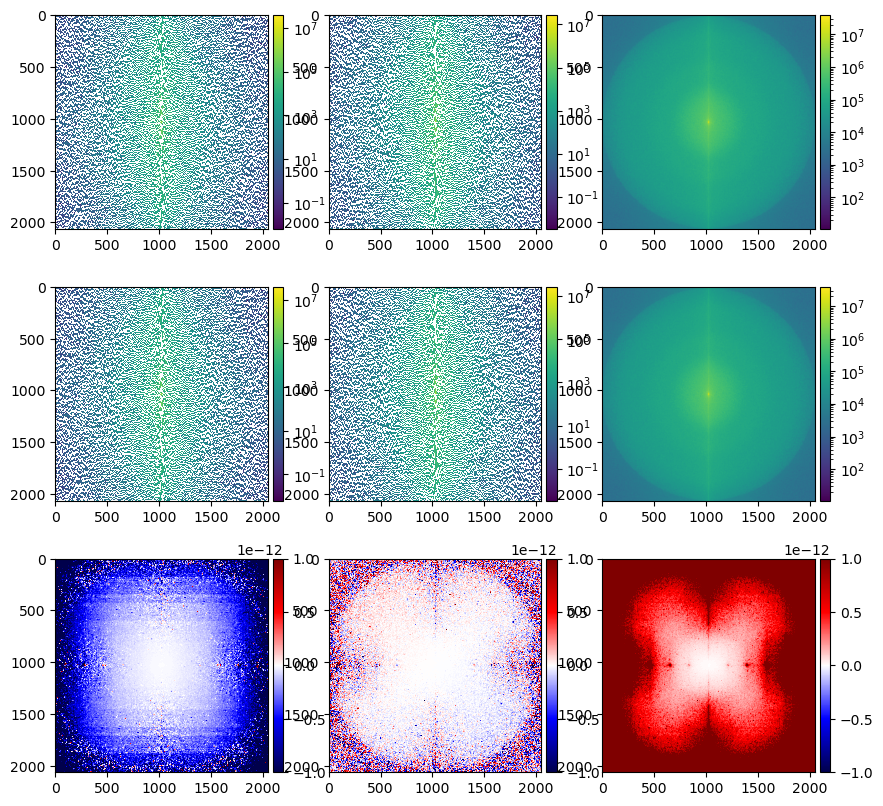

In [6]:
key = 'nuFFT2d1'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
# print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)

fig, ax = plt.subplots(3,3, figsize=(10,10))

resCPU = np.fft.fftshift(defres['CPU'][solverCPU][key].reshape(2*t.ntheta_CAR-2,-1),axes=(0,1))
resGPU = defres['GPU'][solverGPU][key][0].reshape(2*t.ntheta_CAR-2,-1)

im = ax[0,0].imshow(np.real(resCPU), norm='log')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,1].imshow(np.imag(resCPU), norm='log')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,2].imshow(np.abs(resCPU), norm='log')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(np.real(resGPU), norm='log')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(np.imag(resGPU), norm='log')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(np.abs(resGPU), norm='log')
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -1e-12, 1e-12
# vmin, vmax = None, None
im = ax[2,0].imshow(np.real((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(np.imag((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,2].imshow(np.abs((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(2062, 2048) (2062, 2048)


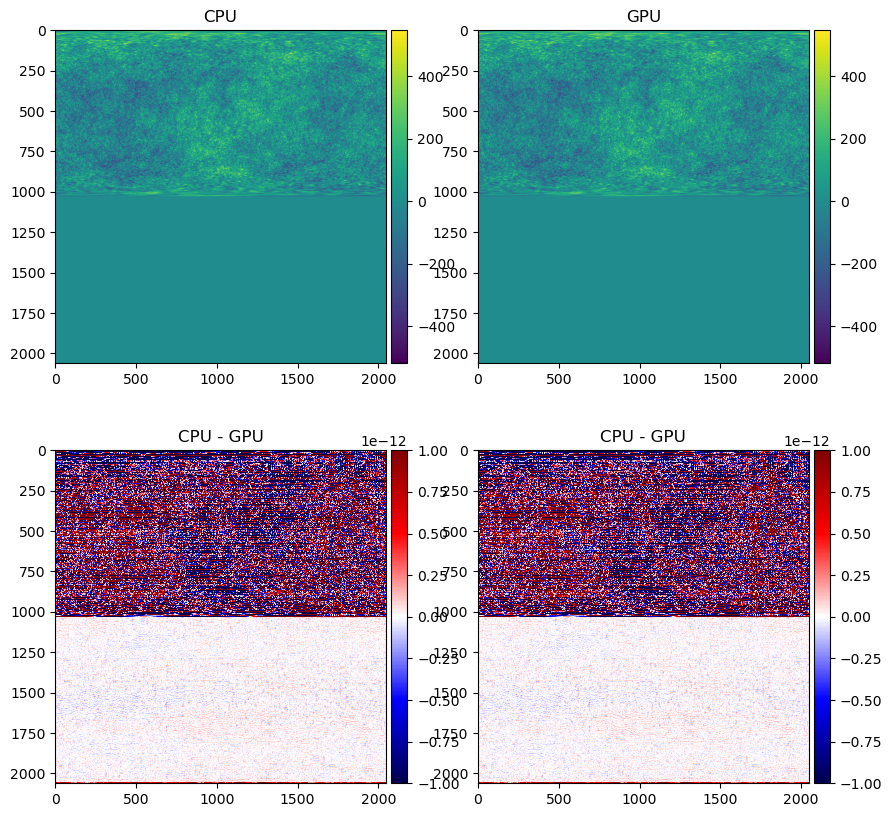

In [13]:
key = 'iC2C'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'

vmin, vmax = -4e2, 4e2
vmin, vmax = None, None
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
Tsky = Tsky2

resCPU = np.real(defres['CPU'][solverCPU][key])#[::2,::2])
resGPU = np.real(defres['GPU'][solverGPU][key])#[::2,::2])
n=1

fig, ax = plt.subplots(2,2, figsize=(10,10))

# ax[0,0].imshow(Tsky[:500*(t.nphi_CAR)].reshape(-1,t.nphi_CAR).real, vmin=vmin, vmax=vmax)
# ax[0,0].imshow(Tsky.reshape(2*t.ntheta_CAR-2,t.nphi_CAR), vmin=vmin, vmax=vmax)
# ax[0,0].set_title('Tsky')

im = ax[0,0].imshow(resCPU.reshape((2*t.ntheta_CAR-2)//n,t.nphi_CAR//n), vmin=vmin, vmax=vmax)
ax[0,0].set_title('CPU')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[0,1].imshow(resGPU.reshape((2*t.ntheta_CAR-2)//n,t.nphi_CAR//n).astype(np.double), vmin=vmin, vmax=vmax)
ax[0,1].set_title('GPU')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -1e-12, 1e-12
im = ax[1,0].imshow((resCPU-resGPU).reshape(-1,t.nphi_CAR), vmin=vmin, vmax=vmax, cmap='seismic')
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow((resCPU-resGPU).reshape(-1,t.nphi_CAR), vmin=vmin, vmax=vmax, cmap='seismic')
ax[1,1].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(-1.0, 1.0)

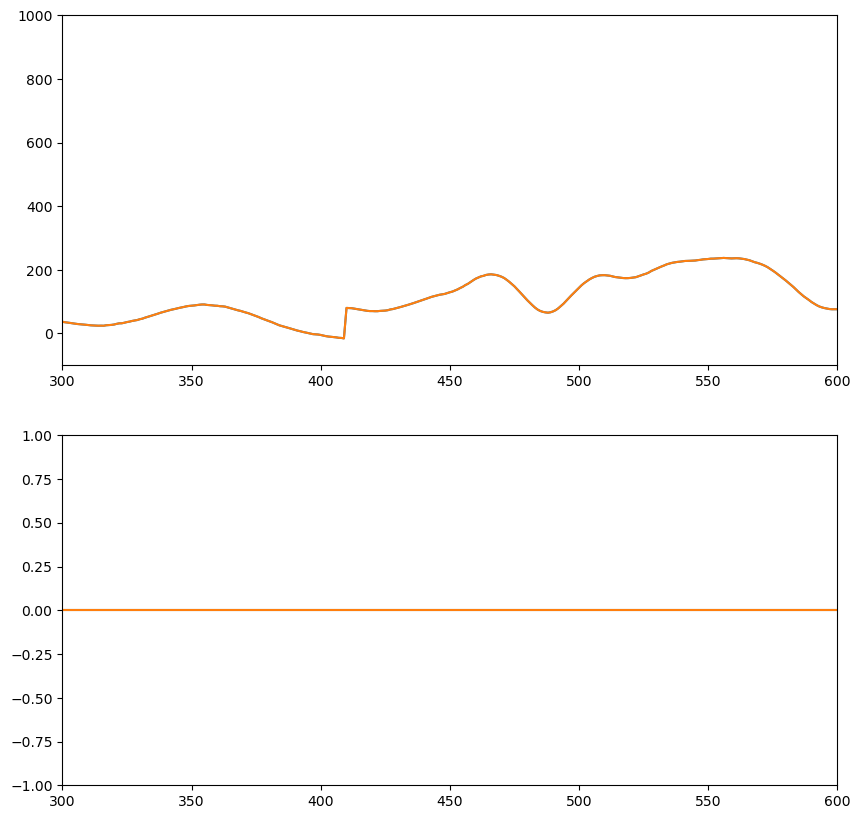

In [21]:
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(resCPU.real.flatten()[::10])
ax[0].plot(resGPU.real.flatten()[::10])
ax[0].set_xlim(0,2e6)
ax[0].set_xlim(300,600)
ax[0].set_ylim(-1e2,1e3)

ax[1].plot(resCPU.imag.flatten()[::1000])
ax[1].plot(resGPU.imag.flatten()[::1000])
ax[1].set_xlim(0,2e6)
ax[1].set_xlim(300,600)
ax[1].set_ylim(-1e0,1e0)
# plt.imshow(defres['GPU'][solverGPU][key][0][::2,::2].real)

(1032, 2048) (1032, 2048)


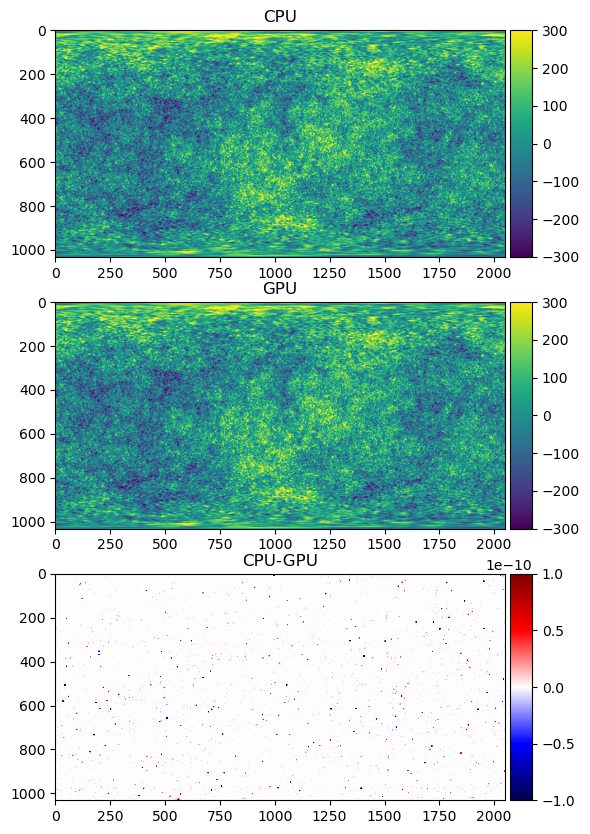

In [26]:
key = 'adjointdoubling'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
fig, ax = plt.subplots(3,1, figsize=(8,10))

resCPU = defres['CPU'][solverCPU][key][0].real
resGPU = defres['GPU'][solverGPU][key].reshape(-1,t.constructor.nphi)
print(resCPU.shape, resGPU.shape)

vmin, vmax = -3e2, 3e2
im = ax[0].imshow(resCPU, vmin=vmin, vmax=vmax)
ax[0].set_title('CPU')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1].imshow(resGPU, vmin=vmin, vmax=vmax)
ax[1].set_title('GPU')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

vmin, vmax = -1e-10, 1e-10
im = ax[2].imshow((resCPU-resGPU)/resCPU, cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


(1, 524800) (1, 524800)


/tmp/ipykernel_2262666/3653238930.py:24: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(resCPU/hp.alm2cl(toyunllm), label=solverCPU)
/tmp/ipykernel_2262666/3653238930.py:25: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(resGPU/hp.alm2cl(toyunllm), label=solverGPU)
/tmp/ipykernel_2262666/3653238930.py:27: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(hp.alm2cl(tlm_unl_1.astype(complex))/hp.alm2cl(toyunllm), label='Juliens test: adjoint_synth(Tlen)')


(0.95, 1.01)

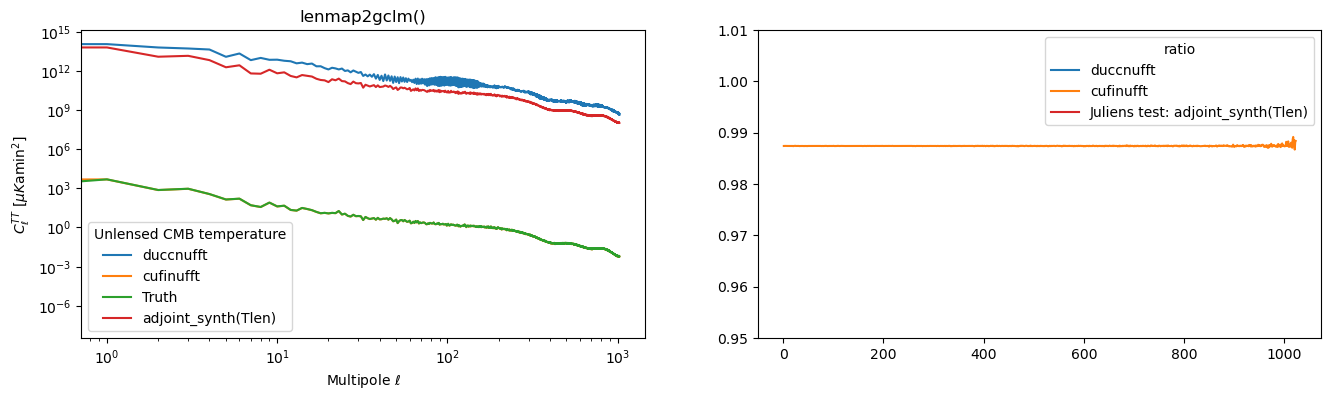

In [8]:
key = 'adjointsynthesis'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
vmin = -1e-10
vmax = 1e-10
fig, ax = plt.subplots(1,2, figsize=(16,4))
print(defres['CPU'][solverCPU][key].shape, defres['GPU'][solverGPU][key].shape)

resCPU = hp.alm2cl(defres['CPU'][solverCPU][key][0])
resGPU = hp.alm2cl(defres['GPU'][solverGPU][key][0])

ax[0].plot(resCPU, label=solverCPU)
ax[0].plot(resGPU, label=solverGPU)
ax[0].plot(hp.alm2cl(toyunllm), label='Truth')

ax[0].plot(hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

ax[1].plot(resCPU/hp.alm2cl(toyunllm), label=solverCPU)
ax[1].plot(resGPU/hp.alm2cl(toyunllm), label=solverGPU)
ax[1].plot(0,0)
ax[1].plot(hp.alm2cl(tlm_unl_1.astype(complex))/hp.alm2cl(toyunllm), label='Juliens test: adjoint_synth(Tlen)')
ax[1].legend(title='ratio')
ax[1].set_ylim(0.95,1.01)
# ax[1].loglog()
# ax[1].plot(hp.alm2cl(), label=solverGPU)